In [1]:
import pandas as pd

from pandas import read_csv
series = read_csv('transaction_data.csv', header=0, parse_dates=True, squeeze=True)

In [2]:
series.sort_values(by=['DAY'])

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.00,0.00
151,718,26985360571,1,934676,1,1.37,324,-0.42,1115,1,-1.00,0.00
153,718,26985360571,1,947849,1,1.25,324,-0.44,1115,1,0.00,0.00
154,718,26985360571,1,948756,3,2.12,324,-0.90,1115,1,-0.75,-0.25
155,718,26985360571,1,950439,1,1.00,324,-0.59,1115,1,0.00,0.00
156,718,26985360571,1,952981,2,1.00,324,-0.98,1115,1,0.00,0.00
157,718,26985360571,1,955043,1,0.50,324,-0.49,1115,1,0.00,0.00
158,718,26985360571,1,962609,2,1.58,324,-0.40,1115,1,0.00,0.00
159,718,26985360571,1,964968,1,1.50,324,-0.99,1115,1,0.00,0.00
160,718,26985360571,1,965292,2,3.50,324,-1.28,1115,1,-1.00,0.00


In [6]:
benchmark=series[0:]
benchmark.to_csv('benchmark.csv', header=False)

In [7]:
#keep only transactions before first campaign which is on day 224
benchmark = benchmark[benchmark['DAY']<224]

In [8]:
benchmark.shape

(627727, 12)

In [9]:
#remove canceled orders
benchmark = benchmark[benchmark['QUANTITY']>0]

In [10]:
print("Summary..")
#exploring the unique values of each attribute
print("Number of transactions: ", benchmark['BASKET_ID'].nunique())
print("Number of products bought: ",benchmark['PRODUCT_ID'].nunique())
print("Number of customers:", benchmark['household_key'].nunique() )

Summary..
Number of transactions:  69775
Number of products bought:  48695
Number of customers: 2495


In [11]:
#Calculation of recency : 
# Step 1 : last date available in our dataset
lastday=benchmark['DAY'].max()
#Step 2: definition of now
now = 223
print(lastday,now)

223 223


In [12]:
#create a new column called date which contains the date of invoice only
benchmark['date'] = (benchmark['DAY'])
#group by customers and check last date of purchase
recency_df = benchmark.groupby(by='household_key', as_index=False)['date'].max()
recency_df.columns = ['household_key','LastPurchaseDate']
recency_df.head()

,household_key,LastPurchaseDate
0,1,219
1,2,222
2,3,223
3,4,216
4,5,223


In [13]:
#calculate recency
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x: (now - x))
#drop LastPurchaseDate as we don't need it anymore

In [14]:
recency_df.drop('LastPurchaseDate',axis=1,inplace=True)
(recency_df.head())

,household_key,Recency
0,1,4
1,2,1
2,3,0
3,4,7
4,5,0


In [15]:
#Calculation of frequency
#Step 1 drop duplicates
benchmark_copy = benchmark
benchmark_copy.drop_duplicates(subset=['BASKET_ID', 'household_key'], keep="first", inplace=True)
#Step 2 calculate frequency of purchases
frequency_df = benchmark_copy.groupby(by=['household_key'], as_index=False)['BASKET_ID'].count()
frequency_df.columns = ['household_key','Frequency']
temp_df = recency_df.merge(frequency_df,on='household_key')

In [16]:
temp_df.head()

,household_key,Recency,Frequency
0,1,4,18
1,2,1,20
2,3,0,17
3,4,7,7
4,5,0,17


In [17]:
temp_df.describe()

,household_key,Recency,Frequency
count,2495.000000,2495.000000,2495.000000
mean,1249.227655,22.296994,27.965932
std,721.639487,38.648743,32.348110
min,1.000000,0.000000,1.000000
25%,624.500000,1.000000,9.000000
50%,1249.000000,6.000000,18.000000
75%,1873.500000,21.000000,35.000000
max,2500.000000,222.000000,351.000000


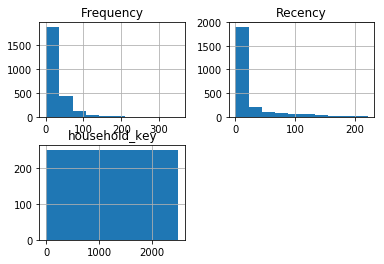

In [19]:
from matplotlib import pyplot
temp_df.hist()
pyplot.show()

In [23]:
#create column total cost
benchmark['TotalCost'] =  benchmark['SALES_VALUE']

In [24]:
monetary_df = benchmark.groupby(by='household_key',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['household_key','Monetary']

In [25]:
tx_user  = temp_df.merge(monetary_df,on='household_key')

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

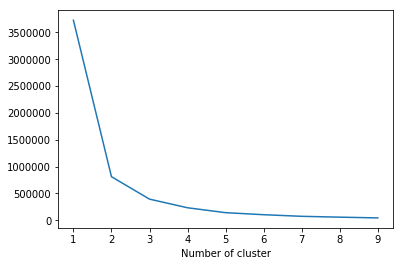

In [26]:
import matplotlib.pyplot as plt
#Select number of clusters for each attributes
#Step 1 : Clusters for Recency
from sklearn.cluster import KMeans

sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [27]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)
#see details of each cluster
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,87.0,164.494253,24.627397,131.0,144.5,159.0,184.0,222.0
1,197.0,96.766497,18.609475,68.0,79.0,97.0,112.0,130.0
2,333.0,38.159159,13.144535,22.0,27.0,35.0,48.0,67.0
3,1878.0,5.085197,5.470236,0.0,1.0,3.0,8.0,21.0


In [28]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

#order the frequency cluster
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

#see details of each cluster
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1605.0,11.861059,7.113614,1.0,6.0,11.0,17.0,26.0
1,675.0,41.054815,11.139457,27.0,31.0,38.0,49.0,66.0
2,192.0,92.036458,23.002020,67.0,75.0,84.0,102.5,160.0
3,23.0,232.826087,51.573119,174.0,191.5,220.0,263.5,351.0


In [29]:
#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Monetary']])
tx_user['MonetaryCluster'] = kmeans.predict(tx_user[['Monetary']])


#order the cluster numbers
tx_user = order_cluster('MonetaryCluster', 'Monetary',tx_user,True)

#show details of the dataframe
tx_user.groupby('MonetaryCluster')['Monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
MonetaryCluster,,,,,,,,
0,1733.0,48.680848,34.345923,0.40,20.01,41.110,72.9400,130.10
1,552.0,211.728080,64.361444,130.16,157.21,193.915,256.6125,366.55
2,169.0,524.460828,124.138575,368.97,425.13,487.300,602.9100,817.80
3,41.0,1167.825854,334.451815,850.59,1008.06,1096.090,1195.6700,2767.46


In [30]:
#calculate overall score and use mean() to see details
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['MonetaryCluster']
tx_user.groupby('OverallScore')['Recency','Frequency','Monetary'].mean()

,Recency,Frequency,Monetary
OverallScore,,,
0,164.494253,2.517241,9.378736
1,96.855615,4.919786,19.625080
2,39.658863,9.665552,36.675585
3,7.876050,14.464286,52.814422
4,5.657407,30.506173,123.811451
5,3.882022,43.592697,218.531573
6,2.778443,71.311377,370.298503
7,1.648649,90.283784,567.658784
8,1.025000,144.225000,984.311500


In [31]:
tx_user.head()

,household_key,Recency,Frequency,Monetary,RecencyCluster,FrequencyCluster,MonetaryCluster,OverallScore
0,1,4,18,47.57,3,0,0,3
1,2,1,20,48.09,3,0,0,3
2,3,0,17,37.28,3,0,0,3
3,4,7,7,20.13,3,0,0,3
4,5,0,17,60.63,3,0,0,3


In [33]:
tx_user= tx_user[0:]
tx_user.to_csv('tx_user.csv', header=True)